In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from skimage import color,io
import glob,cv2,os,natsort,math,time

In [3]:
if __name__ == '__main__':
    ### Fourier & Inverse Fourier Transforms ###
    def F(x):
        return np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(x)))
    def Ft(x):
        return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(x)))

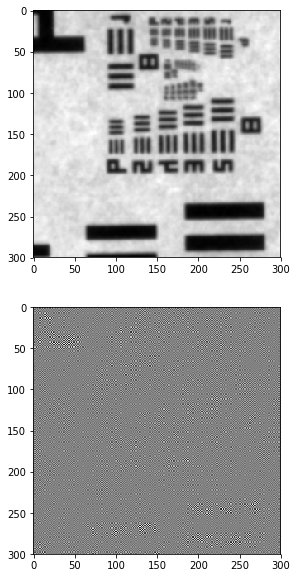

In [5]:

### Load in data and plot ###
amp = color.rgb2gray(io.imread('objR_amplitude.png'))
amp = np.array(amp[150:450,150:450]) # cropping to 300x300 image
phase = color.rgb2gray(io.imread('objR_phase.png'))
phase = np.array(phase[150:450,150:450]) # cropping to 300x300 image
if __name__ == '__main__': 
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(211)
    ax1.imshow(amp,cmap='gray') # plot amplitude
    ax2 = fig.add_subplot(212)
    ax2.imshow(phase,cmap='gray') # plot phase

# Generate object
obj = amp*np.exp(1j*phase) # simulate object (1 object)
pad = 300
obj = np.pad(obj,pad,mode='constant')

# Define variables
lamb = 0.532  # um, wavelength of illumination, assume monochromatic
dpix_c = 6.5 # um, pixel size on the sensor plane, PCO = 6.5um
NA = 0.25    # numerical aperture of objective
mag = 10     # magnification of the system


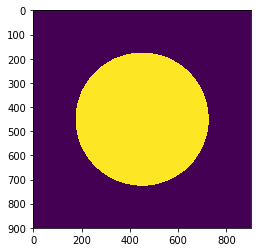

In [7]:
if __name__ == '__main__':
    ### Generate pupil function ###

    NsampR = np.array(np.shape(obj))

    uMax = NA/lamb            # Maximum spatial frequency set by NA (1/um)
    dpix_m = dpix_c/mag       # Effective image pixel size on the object plane (um)
    FoV = NsampR*dpix_m       # FoV in the object space

    du = np.zeros(2)
    if NsampR[0] % 2 == 1:   # ROWS
        du[0] = 1/dpix_m/(NsampR[0]-1)
    else:
        du[0] = 1/FoV[0]     # sampling size at Fourier plane is always 1/FoV
    if NsampR[1] % 2 == 1:   # COLUMNS
        du[1] = 1/dpix_m/(NsampR[1]-1)
    else:
        du[1] = 1/FoV[1]

    uui = (np.arange((-NsampR[1]/2),(NsampR[1]/2)))*du[1]
    vvi = (np.arange((-NsampR[0]/2),(NsampR[0]/2)))*du[0]
    ufi,vfi = np.meshgrid(uui,vvi)

    z = np.zeros(NsampR)
    xx = np.arange((-NsampR[1]/2),(NsampR[1]/2))*dpix_c/mag
    yy = np.arange((-NsampR[0]/2),(NsampR[0]/2))*dpix_c/mag
    II,JJ = np.meshgrid(xx,yy) # create x and y coords of object

    ci,cj = round(len(z)/2),round(len(z[0])/2)
    cr=uMax/du[1]
    dist = np.sqrt(ufi**2+vfi**2)
    pupil = dist < uMax
    plt.imshow(pupil)

In [7]:
if __name__ == '__main__':
    ### NA for different illumination angle images ###

    max_NA = 0.35
    r_led = 7 #radius, in unit of "# of leds"
    [NA_x, NA_y] = np.meshgrid(np.linspace(-max_NA, max_NA, 2*r_led+1), np.linspace(-max_NA, max_NA, 2*r_led+1))
    NA_x[np.arange(1, NA_x.shape[0], 2), :] = NA_x[np.arange(1, NA_x.shape[0], 2), ::-1] #Flip every other column
    #Limit down to a circle
    valid_led = (NA_x**2+NA_y**2) <= (max_NA**2)
    NA_y = NA_y[valid_led]
    NA_x = NA_x[valid_led]

    number_images = 149


In [8]:
if __name__ == '__main__':
    ### Generate different illumination angle images ###

    P = pupil

    I_meas = np.zeros((np.shape(obj)[0],np.shape(obj)[1],number_images))
    for i in range(number_images):
        tilt_illum = (np.exp(1j*(2*np.pi)*(II*NA_x[i]/lamb+JJ*NA_y[i]/lamb)))
        obj_ill_F = F(obj*tilt_illum)
        obj_ill_filt = obj_ill_F*P
        I_meas[:,:,i] = (np.abs(Ft(obj_ill_filt)))**2


In [9]:
if __name__ == '__main__':
    ### Save images ###

    for i in range(number_images):
        plt.imsave(r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\scripts\simulated_images\regina_sample_data\image_'+\
                   str(i)+'.png',I_meas[pad:len(obj)-pad,pad:len(obj)-pad,i])

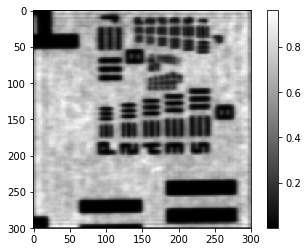

In [20]:
if __name__ == '__main__':
    ### imshow ###

    plt.imshow(I_meas[pad:len(obj)-pad,pad:len(obj)-pad,70],cmap='gray')
    plt.colorbar()